[18, 11, 4, 11, 4, 11, 4, 11, 4, 11, 4, 11, 18, 25, 32, 39, 40]
16 steps in episode 1
[18, 25, 32, 39, 40]
4 steps in episode 2
[18, 25, 32, 39, 40]
4 steps in episode 3
[18, 25, 32, 39, 40]
4 steps in episode 4
[18, 25, 32, 39, 40]
4 steps in episode 5
[18, 25, 32, 39, 40]
4 steps in episode 6
[18, 25, 32, 39, 40]
4 steps in episode 7
[18, 25, 32, 39, 40]
4 steps in episode 8
[18, 25, 32, 39, 40]
4 steps in episode 9
[18, 25, 32, 39, 40]
4 steps in episode 10
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.83135739  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.        

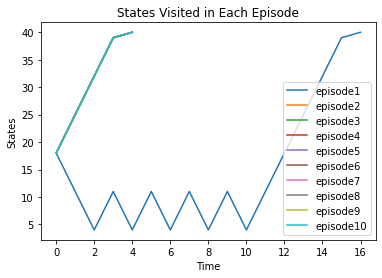

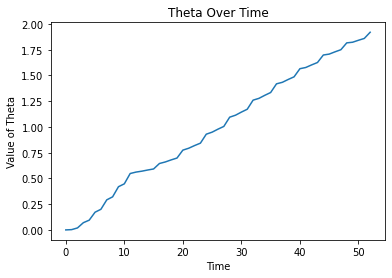

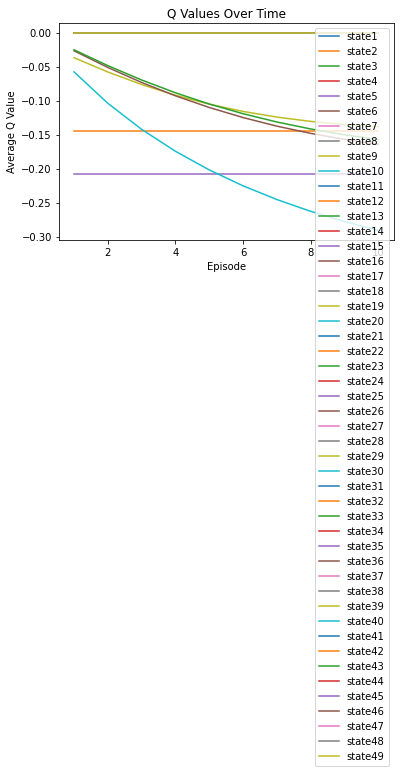

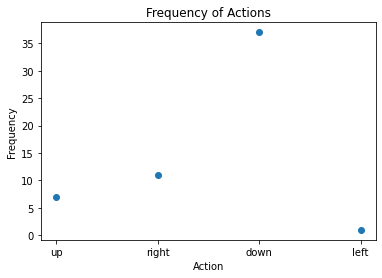

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

STATES = 49
SUM = 4
EPISODES = 10
ACTIONS = ["up", "right", "down", "left"] #final matrix for my reference to show the different actions
ACTION_COUNT = [1, 1, 1, 1]
ACTION_PROB = np.true_divide(ACTION_COUNT, SUM)
THETA = 0.0
ALPHA = 0.1
GAMMA = 0.9
BETA = 1
REWARD_TABLE = np.zeros((STATES, len(ACTIONS)), dtype=int)
TRANSITION_MATRIX = np.zeros((STATES, STATES, len(ACTIONS)), dtype=int)

#table: -1 -1 -1 -1  0 -1 -1
#       -1 -1 -1 -1  0 -1 -1  
#       -1 -1  0  0  S  0  0  
#       -1 -1  0 -1  0 -1 -1 
#       -1 -1  B  0  0 -1 -1 
#       -1 -1 -1 -1  0  A -1 
#       -1 -1 -1 -1 -1 -1 -1  
#4 steps for each, 1 turn for each, 1 path for A, 2 paths for B
def build_reward_table(): #hardcoded but based on table
    global REWARD_TABLE
    REWARD_TABLE[23][2] = 1
    REWARD_TABLE[31][3] = 1
    REWARD_TABLE[39][1] = 1
    
def build_transition_matrix(): #hardcoded but based on table 
    global TRANSITION_MATRIX
    for x in range(4, 40, 7):
        if x != 4 and x != 39:
            TRANSITION_MATRIX[x][x - 7][0] = 1
        if x != 39:
            TRANSITION_MATRIX[x][x + 7][2] = 1
    
    for x in range(16, 21):
        if x != 16:
            TRANSITION_MATRIX[x][x - 1][3] = 1
        if x != 16 and x != 20:
            TRANSITION_MATRIX[x][x + 1][1] = 1
            
    TRANSITION_MATRIX[16][23][2] = 1
    TRANSITION_MATRIX[23][30][2] = 1

    TRANSITION_MATRIX[32][31][3] = 1
    TRANSITION_MATRIX[31][30][3] = 1

    TRANSITION_MATRIX[39][40][1] = 1

def create_q_table(states, actions):
    return np.zeros((states, len(actions)))

def pick_action(state, q_table): 
    policies = []
    legal_actions = []
    global ACTION_PROB
    for x in range(len(ACTIONS)):
        if find_new_state(state, x) != state:
            action_prob = ACTION_PROB[x]
            exp = 1 + (THETA * q_table[state, x]) + math.log(action_prob)
            policies.append(math.exp(exp))
            legal_actions.append(x)
    policies = np.true_divide(policies, np.sum(policies))
    if all(elem == policies[0] for elem in policies) and state == 24:
        action = 0
        #action = np.random.choice(legal_actions)
    else:
        action = legal_actions[np.argmax(policies)]
    global ACTION_COUNT
    if action == 0:
        ACTION_COUNT[0] += 1
    elif action == 1:
        ACTION_COUNT[1] += 1
    elif action == 2:
        ACTION_COUNT[2] += 1
    else:
        ACTION_COUNT[3] += 1
    global SUM
    SUM += 1
    ACTION_PROB = np.true_divide(ACTION_COUNT, SUM)
    return action, np.max(policies)

def find_new_state(state, action): 
    new_state = -1
    for x in range(STATES):
        if TRANSITION_MATRIX[state][x][action] == 1:
            new_state = x
    if new_state == -1:
        return state
    else:
        return new_state
    
def policy_cost(p_a_s):  
    action_prob = ACTION_PROB[action]
    policy = p_a_s/action_prob
    return math.log(policy)
    
def planning_cost(state):
    count = 0
    for x in range(len(ACTIONS)):
        if TRANSITION_MATRIX[state][0][x] != 0:
            count += 1
    return count

if __name__ == "__main__":
    q_table = create_q_table(STATES, ACTIONS)
    build_reward_table()
    build_transition_matrix()
    Q_VALUES = np.zeros((STATES, EPISODES))
    EPISODES_ARR = np.arange(1, EPISODES + 1)
    TOTAL_TIME = [0]
    THETA_TIME = [0.0]
    fig1, ax1 = plt.subplots()
    for episode in EPISODES_ARR:
        terminated = False
        currstate = 18
        steps = 0
        states = [currstate]
        time = [steps]
        while not terminated:
            action, p_a_s = pick_action(currstate, q_table)
            r_t = REWARD_TABLE[currstate, action]
            newstate = find_new_state(currstate, action)
            r_t = r_t - 1 #c_1, or action cost, is equal to 1
            q_predict = q_table[currstate, action]
            if r_t == 0:
                terminated = True
            q_target = np.max(q_table[newstate, :]) 
            RPE = r_t + (GAMMA * q_target) - q_predict - ((1/BETA) * policy_cost(p_a_s)) - (0.25 * planning_cost(currstate))
            q_table[currstate, action] += ALPHA * RPE
            THETA += ALPHA * RPE * q_table[currstate, action]
            currstate = newstate
            steps += 1
            states.append(currstate)
            time.append(steps)
            TOTAL_TIME.append(SUM - 4)
            THETA_TIME.append(THETA)
        ax1.plot(time, states, label="episode" + str(episode))
        for state in range(STATES):
            avg_q = 0
            for action in range(len(ACTIONS)):
                avg_q += q_table[state][action]
            Q_VALUES[state][episode - 1] = avg_q/4
        print(steps, "steps in episode", episode)
    ax1.legend(loc="lower right")
    ax1.set(title="States Visited in Each Episode", ylabel="States", xlabel="Time")
    fig2, ax2 = plt.subplots()
    ax2.plot(TOTAL_TIME, THETA_TIME)
    ax2.set(title="Theta Over Time", ylabel="Value of Theta", xlabel="Time")
    fig3, ax3 = plt.subplots()
    for state in range(STATES):
        ax3.plot(EPISODES_ARR, Q_VALUES[state, :], label="state" + str(state + 1))
    ax3.legend(loc="best")
    ax3.set(xlabel="Episode", ylabel="Average Q Value", title="Q Values Over Time")
    fig4, ax4 = plt.subplots()
    ax4.scatter(ACTIONS, ACTION_COUNT)
    ax4.set(title="Frequency of Actions", ylabel="Frequency", xlabel="Action")
    print(q_table)